In [1]:
import csv 
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
filename = '../data/champion.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)

# contains index of championId and name
id_champ_map = {}
champion_list = []
for i, c in enumerate(champ_data['data'].keys()):
    id_champ_map[int(champ_data['data'][c]['key'])] = {'champion': champ_data['data'][c]['id'], 'index': i}
    champion_list.append(champ_data['data'][c]['id'])

In [4]:
filename = '../data/complete_mastery_info.json'

with open(filename, 'r') as f:
    data = json.load(f)

skipped = {}
ratings = [] # list of items
r = np.zeros((len(data.keys()), len(champion_list)))
percent = 0.9
skip = 4
for i, key in enumerate(data.keys()):
    used = []
    for j, entry in enumerate(data[key]):
        if j == 0:
            # sorted in descending order
            maximum = entry['championPoints']
        
        if j + 1 == skip and i > (len(data.keys())*percent):
            item = id_champ_map[entry['championId']]['champion']
            skipped[key] = id_champ_map[entry['championId']]['champion'] # add key, item, and rank #
        else:    
            score = entry['championPoints']/maximum
            item = id_champ_map[entry['championId']]['champion']
            ratings.append([key, item, score])
            used.append(item)
    # set unknown champion IDs to zero
    for champ in champion_list:
        if champ not in used:
            ratings.append([key, champ, 0])
    else:
        continue

print(f'users: {i}')
print(f'ratings: {len(ratings)}')
with open('../data/surprise_data_test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ratings)
    
with open('../data/surprise_data_omit.csv', 'w', newline='') as f:
    json.dump(skipped, f, indent=4)

users: 2896
ratings: 478005


In [5]:
import pprint

from surprise import Dataset, Reader, accuracy, KNNWithMeans, SVD, NormalPredictor
from collections import defaultdict

In [6]:
test_path = os.path.expanduser('../data/surprise_data_test.csv')
file_path = test_path
reader = Reader(sep=',', rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

In [7]:
most_played = {}

with open(file_path, 'r') as f:
    reader_obj = csv.reader(f)
    cur_id = ''
    most = []
    for row in reader_obj: 
        user_id, champion, score = row
        if cur_id != user_id:
            if cur_id != '':
                most_played[cur_id] = most
                most = []
            cur_id = user_id
        
        most.append(champion)

In [12]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

trainset = data.build_full_trainset()
#algo = KNNWithMeans(sim_options=sim_options)
#algo = SVD()
algo = NormalPredictor()
algo.fit(trainset)

In [13]:
mean_rating = {}

for rating in trainset.all_ratings():
    __, iid, rate = rating
    iid = trainset.to_raw_iid(iid)
    if iid not in mean_rating.keys():
        mean_rating[iid] = {'score': rate, 'n': 1, 'mean': rate}
    else:
        mean_rating[iid]['score'] += rate
        mean_rating[iid]['n'] += 1
        mean_rating[iid]['mean'] = mean_rating[iid]['score']/mean_rating[iid]['n']

In [14]:
def get_top_n(uid, algo, champion_list, champs_played, n=10, ignore=5):
    top_n = defaultdict(list)
    for champ in champion_list:
        if champ not in champs_played[:ignore]:
            #top_n[uid].append((champ,algo.predict(uid, champ).est))
            top_n[uid].append((champ,algo.predict(uid, champ).est/mean_rating[iid]['mean']))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n[uid]

def recommendChampion(uid, champs_played, champion_list, algo, n=10, ignore=5):
    print(f'User ID: {uid}')
    pprint.pprint(champs_played[:ignore])
    print(f'Recommendations for {uid}')
    count = 0
    for rec in get_top_n(uid, algo, champion_list, champs_played, n=n, ignore=ignore):
        print(rec[0])

In [15]:
inside_5 = 0
inside_10 = 0
inside_15 = 0
tot = 0

for user in skipped.keys():
    if user not in most_played.keys():
        continue
    
    top_n = get_top_n(user, algo, champion_list, most_played[user], n=15)
    for i, item in enumerate(top_n[:15]):
        if skipped[user] == item[0]:
            if i < 5: 
                inside_5 += 1
            if i < 10:
                inside_10 += 1
            if i < 15:
                inside_15 += 1

    tot += 1

print(inside_5/tot)
print(inside_10/tot)
print(inside_15/tot)

0.041666666666666664
0.06944444444444445
0.10069444444444445


## Testing Number of Good Guesses (N = [5,14])

For this test, I presented my model with the top N champion mastery data for 10% of users in the dataset while all champion mastery data for the other 90% of users was presented to the model. 

For the 10% of users which only presented their top N champions, I saved the next 5 champions. For example if N = 3 and the top 8 champions for a user are [Ashe, Ahri, Aatrox, Yasuo, Yone, Pantheon, DrMundo, Bard] then I would present [Ashe, Ahri, Aatrox] to the model and save [Yasuo, Yone, Pantheon, DrMundo, Bard] since they should be the next best predictions. I then counted how many times each model chose a character from this saved pool for each user which I called a "good guess". I then calculated the average number of good guesses in the top 5, top 10, and top 15 recommended champions. This number was only calculated from users in the 10% testing set.

This showed a clear hierarchy with KNN beating SVD which beat Random

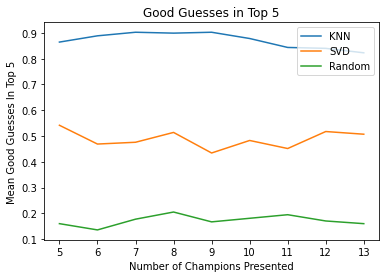

In [28]:
filename = '../data/test_data/all_vals_n_predicted_6_to_10.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)
x = np.arange(5, 14)

plt.plot(x, champ_data['KNN']['top5'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top5'], label = 'SVD')
plt.plot(x,champ_data['Random']['top5'], label = 'Random')
plt.title("Good Guesses in Top 5")
plt.xlabel("Number of Champions Presented")
plt.ylabel("Mean Good Guesses In Top 5")
plt.legend()

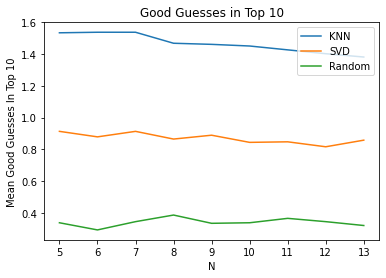

In [31]:
plt.plot(x, champ_data['KNN']['top10'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top10'], label = 'SVD')
plt.plot(x,champ_data['Random']['top10'], label = 'Random')
plt.title("Good Guesses in Top 10")
plt.xlabel("N")
plt.ylabel("Mean Good Guesses In Top 10")
plt.legend()

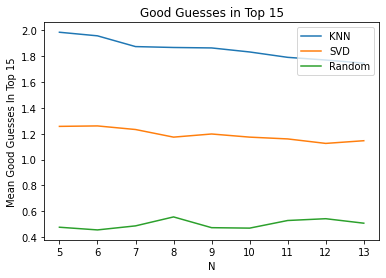

In [32]:
plt.plot(x, champ_data['KNN']['top15'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top15'], label = 'SVD')
plt.plot(x,champ_data['Random']['top15'], label = 'Random')
plt.title("Good Guesses in Top 15")
plt.xlabel("N")
plt.ylabel("Mean Good Guesses In Top 15")
plt.legend()

# Rank Metric (KNN, SVD, Random) on Individual Ranks


The sklearn surprise package doesn't let you present a new vector with champion rank scores to its KNN model, so I had to find a new way to test unknown high ranked values. To do this, I removed the nth ranked character's data in 10% of users. For example if n = 1, then I removed the top ranked character from 10% of users and then trained on that dataset. I then trained and ran the KNN, SVD, and Random models and calculated the probability that the removed character was suggested. This showed that KNN performed slightly better than SVD, and that both algorithms performed marginally better than random. It also showed that the KNN and SVD algorithms are more likely to suggest higher ranked champions since they decreased as n increased.

# Test Set (10%) for Top 25 Champion Mastery Points Saved (5.4k users)

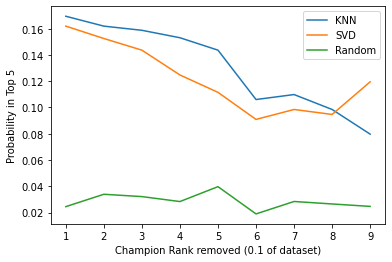

In [19]:
filename = '../data/test_data/rank_metric_25_vals.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)
x = np.arange(1, 10)

plt.plot(x, champ_data['KNN']['top5'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top5'], label = 'SVD')
plt.plot(x,champ_data['Random']['top5'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 5")
plt.legend()

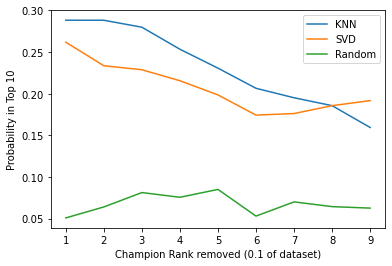

In [20]:
plt.plot(x, champ_data['KNN']['top10'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top10'], label = 'SVD')
plt.plot(x,champ_data['Random']['top10'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 10")
plt.legend()

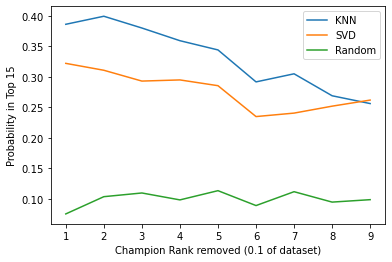

In [21]:
plt.plot(x, champ_data['KNN']['top15'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top15'], label = 'SVD')
plt.plot(x,champ_data['Random']['top15'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 15")
plt.legend()

In [22]:
pprint.pprint(champ_data)

{'KNN': {'top10': [0.288135593220339,
                   0.288135593220339,
                   0.27977315689981097,
                   0.2533081285444234,
                   0.23062381852551986,
                   0.20643939393939395,
                   0.19507575757575757,
                   0.1856060606060606,
                   0.15939278937381404],
         'top15': [0.3860640301318267,
                   0.3992467043314501,
                   0.3799621928166352,
                   0.3591682419659735,
                   0.3440453686200378,
                   0.2916666666666667,
                   0.30492424242424243,
                   0.2689393939393939,
                   0.25616698292220114],
         'top5': [0.1694915254237288,
                  0.16195856873822975,
                  0.15879017013232513,
                  0.15311909262759923,
                  0.14366729678638943,
                  0.10606060606060606,
                  0.10984848484848485,
                  0

# Test Set (10%) for All Champion Mastery Points Saved (2.9k users)

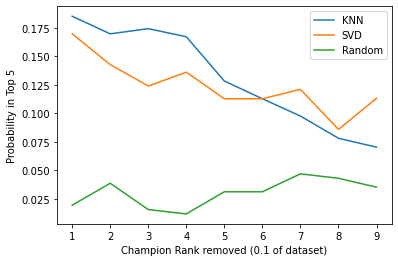

In [23]:
filename = '../data/test_data/rank_metric_all_vals.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)
x = np.arange(1, 10)

plt.plot(x, champ_data['KNN']['top5'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top5'], label = 'SVD')
plt.plot(x,champ_data['Random']['top5'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 5")
plt.legend()

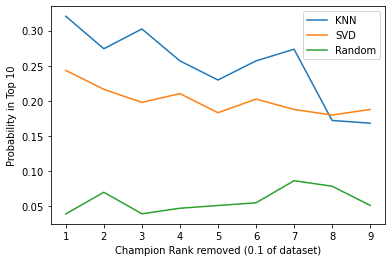

In [24]:
plt.plot(x, champ_data['KNN']['top10'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top10'], label = 'SVD')
plt.plot(x,champ_data['Random']['top10'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 10")
plt.legend()

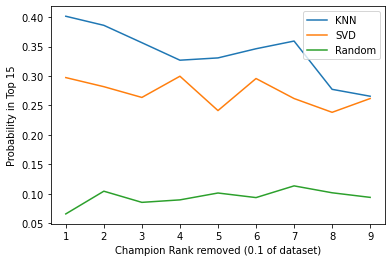

In [25]:
plt.plot(x, champ_data['KNN']['top15'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top15'], label = 'SVD')
plt.plot(x,champ_data['Random']['top15'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 15")
plt.legend()

## Training Set Rank Metric

KNN Metric very high for training set (as expected)

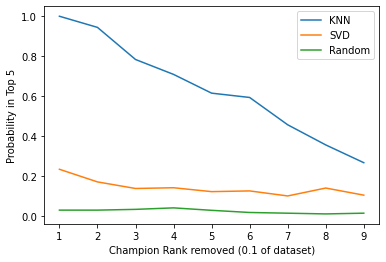

In [26]:
filename = '../data/test_data/rank_metric_all_vals_training_data.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)
x = np.arange(1, 10)

plt.plot(x, champ_data['KNN']['top5'], label = 'KNN')
plt.plot(x, champ_data['SVD']['top5'], label = 'SVD')
plt.plot(x,champ_data['Random']['top5'], label = 'Random')
plt.xlabel("Champion Rank removed (0.1 of dataset)")
plt.ylabel("Probability in Top 5")
plt.legend()